*Notebook source: https://www.kaggle.com/code/serkanpeldek/face-recognition-on-olivetti-dataset*

Note -- This might be better (later change)  
https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

<hr>

### Load dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
lfw_people = fetch_lfw_people()

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 13233
n_features: 2914
n_classes: 5749


In [11]:
y

array([5360, 3434, 3807, ..., 2175,  373, 2941], dtype=int64)

In [6]:
lfw_people.images.shape

(13233, 62, 47)

In [7]:
data = lfw_people.images

### Show Image

In [8]:
def show_10_faces_of_n_subject(images, subject_ids):

    cols=10 # each subject has 10 distinct face images
    rows=(len(subject_ids)*10)/cols
    rows=int(rows)
    
    fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(18,9), facecolor='white')
    # axarr = axarr.flatten()
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index = subject_id*10 + j
            axarr[i,j].imshow(images[image_index], cmap='gray')
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title('face id:{}'.format(subject_id))

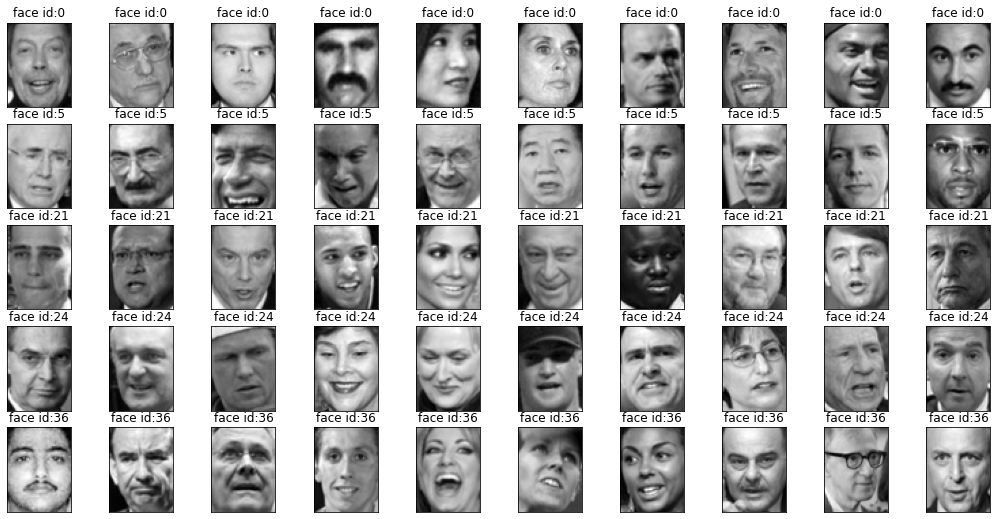

In [9]:
show_10_faces_of_n_subject(images=data, subject_ids=[0,5, 21, 24, 36])

### Prepare dataset for PCA

In [9]:
X = data.reshape((data.shape[0], -1))
print('X shape:', X.shape)

X shape: (400, 4096)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, stratify=target, random_state=0)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (280, 4096)
y_train shape: (280,)


<Axes: title={'center': 'Number of Samples for Each Classes'}, xlabel='subject ids'>

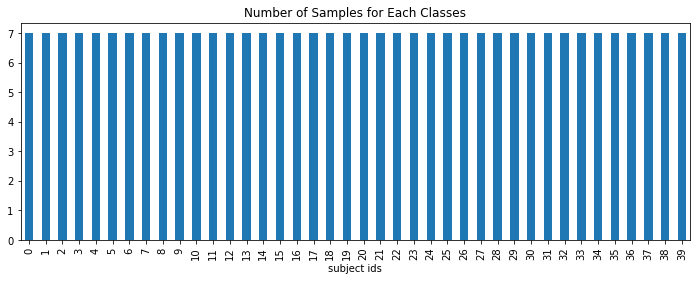

In [11]:
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(12,4), title='Number of Samples for Each Classes')

In [12]:
# import mglearn
# mglearn.plots.plot_pca_illustration()

# This code blocks shows using fake data, not related to our dataset

In [13]:

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

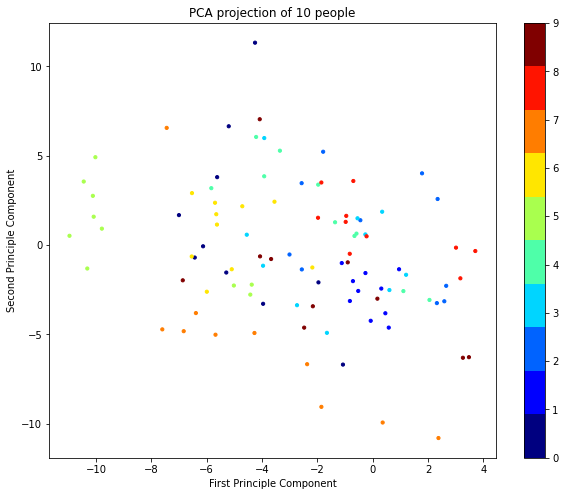

In [14]:
number_of_people = 10
index_range = number_of_people*10

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
scatter = ax.scatter(
    X_pca[:index_range,0],
    X_pca[:index_range,1], 
    c=target[:index_range],
    s=10,
    cmap=plt.get_cmap('jet', number_of_people)
)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')
ax.set_title('PCA projection of {} people'.format(number_of_people))
fig.colorbar(scatter)

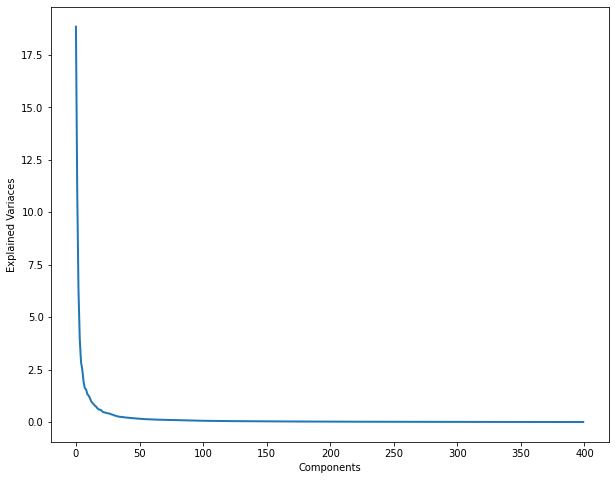

In [15]:
pca = PCA()
pca.fit(X)

plt.figure(1, figsize=(10,8))
plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [16]:
pca = PCA(n_components=90, whiten=True)
pca.fit(X_train)

PCA(n_components=90, whiten=True)

Text(0.5, 1.0, 'Average Face')

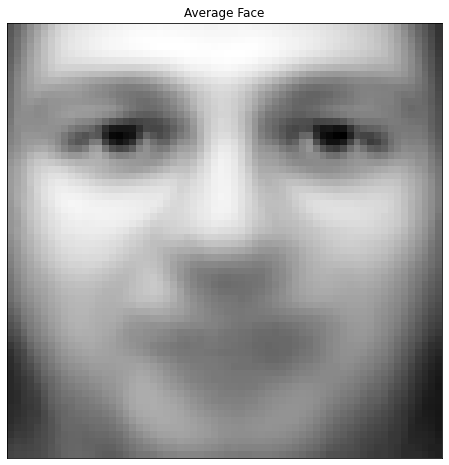

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,8), facecolor='white')
ax.imshow(pca.mean_.reshape((64,64)), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

Text(0.5, 0.98, 'All Eigen Faces')

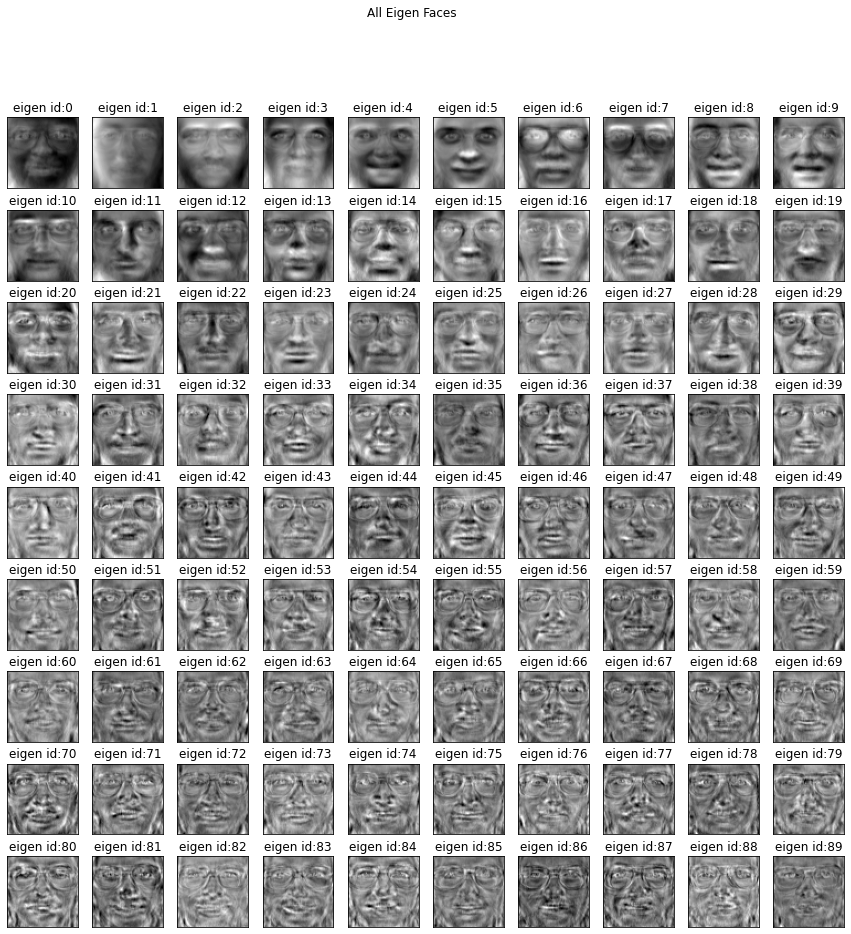

In [18]:
number_of_eigenfaces = len(pca.components_)
eigen_faces = pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))

cols = 10
rows = int(number_of_eigenfaces/cols)
fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15), facecolor='white')
axarr = axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap='gray')
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title('eigen id:{}'.format(i))
plt.suptitle('All Eigen Faces'.format(10*'=', 10*'='))

In [19]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [20]:
print(X_train_pca.shape)
print(y_train.shape)
print(X_test_pca.shape)
print(y_test.shape)

(280, 90)
(280,)
(120, 90)
(120,)


### Machine learning

In [21]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout

from keras import regularizers

In [22]:
y_train = to_categorical(y_train, 40)
y_test = to_categorical(y_test, 40)

print(y_train.shape)
print(y_test.shape)

(280, 40)
(120, 40)


In [23]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=90))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(40, activation='softmax'))

epochs = 100
batch_size = 128
red_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               23296     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 40)                5

In [24]:
history = model.fit(X_train_pca, y_train, epochs=epochs, validation_data=(X_test_pca,y_test), batch_size=128, verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 107ms/step - loss: 3.7997 - accuracy: 0.0143 - val_loss: 3.6549 - val_accuracy: 0.0167
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 3.5977 - accuracy: 0.0250 - val_loss: 3.5791 - val_accuracy: 0.0500
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 3.4927 - accuracy: 0.0750 - val_loss: 3.5139 - val_accuracy: 0.1333
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 3.3858 - accuracy: 0.1643 - val_loss: 3.4491 - val_accuracy: 0.1917
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 3.2629 - accuracy: 0.2107 - val_loss: 3.3775 - val_accuracy: 0.3083
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 3.1798 - accuracy: 0.2821 - val_loss: 3.2947 - val_accuracy: 0.3333
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 3.0633 - accuracy: 0.3857 - val_loss: 3.1978 - val_accuracy: 0.3750
Epoch 8/100
3/3 [==

In [25]:
model.save('models/face_rec_keras.h5')

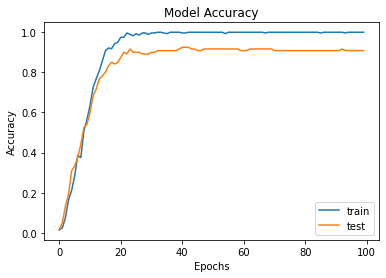

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

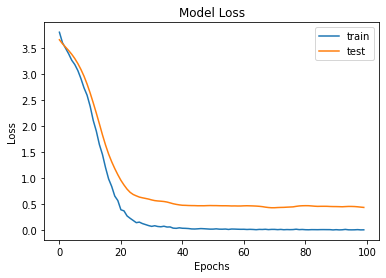

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()